In [1]:
import torch 
import json
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from tqdm.auto import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

plt.rcParams["figure.figsize"] = (8, 4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def process_tags(tags): 
    tags = list(map(int, tags.split(",")))
    return tags

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [4]:
train.head()

,track,tags
0,49734,"5,6,9,26,32,55,96"
1,67845,"6,9,28,39,145,155"
2,25302,"0,6,28,40,116,168"
3,57796,"28,186"
4,13676,"6,23,177"


In [21]:
# train, val = train_test_split(train, test_size=0.1, random_state=42)
# train["stage"] = "train"
# val["stage"] = "val"
# meta = pd.concat((train, val), ignore_index=True)
# meta.to_csv("../data/metadata.csv", sep="\t", index=False)

In [22]:
# meta = pd.read_csv("../data/metadata.csv", sep="\t")
# meta["one_label"] = meta["tags"].parallel_apply(process_tags)
# meta = meta.explode("one_label", ignore_index=True)
# meta.to_csv("../data/metadata_exploded.csv", index=False, sep="\t")

In [5]:
tags = train.tags.apply(process_tags)

In [6]:
all_tags = tags.explode()
tags_count = all_tags.value_counts()
all_tags = all_tags.values.astype(np.int32)
tags_count

0      20095
1      18519
2       7139
6       6270
5       5217
       ...  
184      222
229      215
235      213
211      209
238      208
Name: tags, Length: 256, dtype: int64

In [7]:
len(tags_count)

256

In [8]:
tags_count.sort_index()

0      20095
1      18519
2       7139
3       4777
4       1929
       ...  
251      247
252      265
253      225
254      235
255      243
Name: tags, Length: 256, dtype: int64

# Save weights for WeightBCELoss

In [29]:
import torch 
weights = torch.from_numpy(1 / tags_count.sort_index().values).float()
torch.save(weights, "../data/bce_class_weights.pth")
sum(weights)

tensor(0.6382)

<BarContainer object of 256 artists>

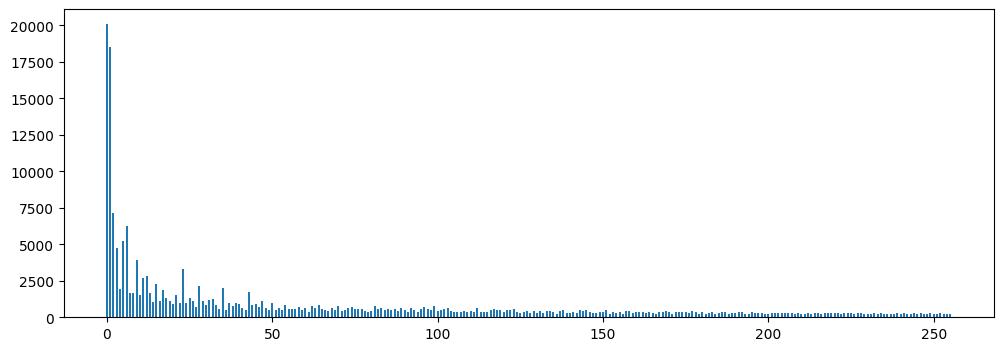

In [12]:
plt.bar(range(len(tags_count)), tags_count.sort_index().values, width=0.6)

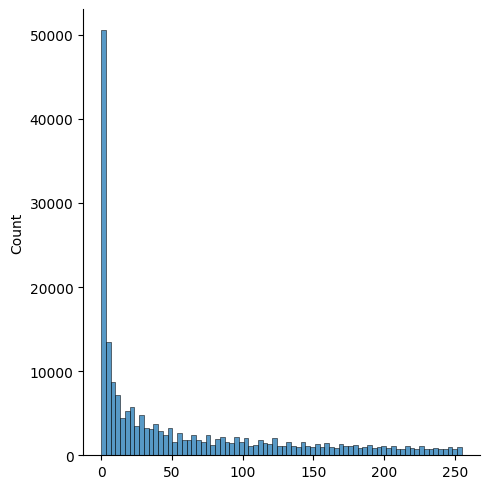

In [13]:
sns.displot(all_tags)

In [25]:
# pred_filepath = "../_EXPERIMENTS/10folds__transformer_attn_pooling_lion_512dim_1/prediction.csv"
# pred_filepath = "../_EXPERIMENTS/transformer_dim512_flip_cut_aug_resample_loss_1/prediction.csv"
pred_filepath = "../_EXPERIMENTS/transformer_attn_pooling_2/prediction.csv"
pred = pd.read_csv(pred_filepath)

def process_pred(pred):
    pred = list(map(float, pred.split(",")))
    tags = []
    for i, p in enumerate(pred):
        if p > 0.5:
            tags.append(i)
    if not tags:
        tags.append(np.argmax(pred))
    return tags
pred.tags = pred.prediction.parallel_apply(process_pred)

/tmp/ipykernel_39870/1714200448.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pred.tags = pred.prediction.parallel_apply(process_pred)


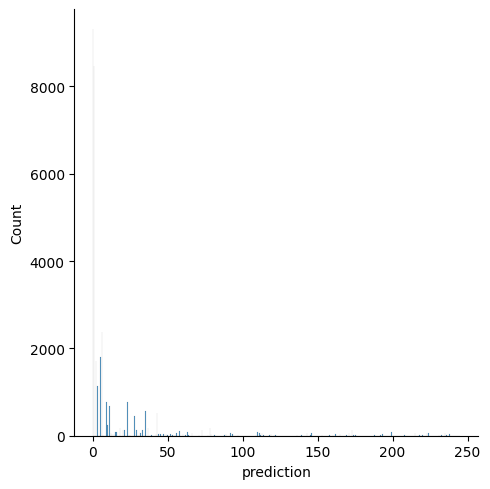

In [26]:
pred_tags_cnt = pred.tags.value_counts()
# plt.bar(range(len(pred_tags_cnt)), pred_tags_cnt.sort_index().values, width=0.6)
sns.displot(pred.tags.explode())

# Separate Head & Tail  

In [9]:
# separate head and tail
bound = 50
sorted_tags = tags_count.index.values
head_tags = sorted_tags[:bound]
tail_tags = sorted_tags[bound:]

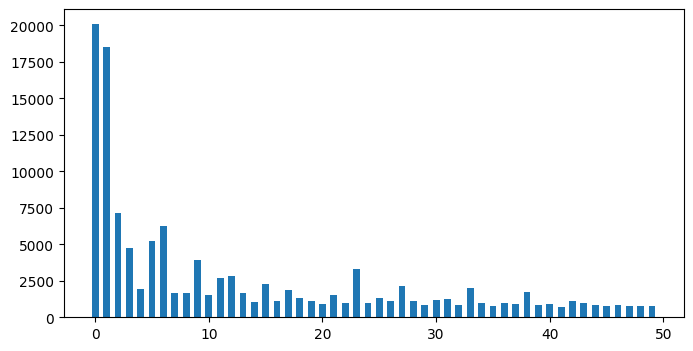

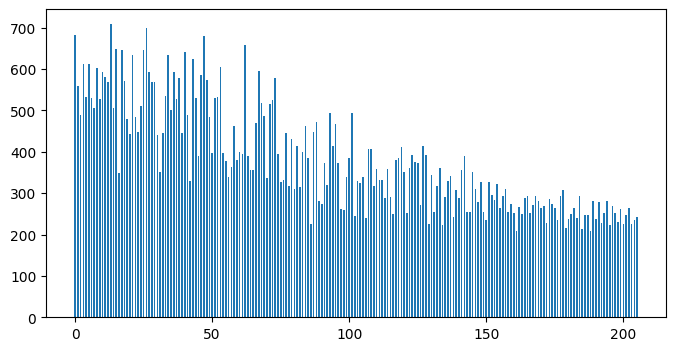

In [10]:
t = tags_count.iloc[:bound]
plt.bar(range(len(t)), t.sort_index().values, width=0.6)
plt.show()

t = tags_count.iloc[bound:]
plt.bar(range(len(t)), t.sort_index().values, width=0.6)
plt.show()

In [11]:
head_mask = tags.apply(lambda tag_list: len(set(tag_list).intersection(set(head_tags))) > 0)
tail_mask = tags.apply(lambda tag_list: len(set(tag_list).intersection(set(tail_tags))) > 0)

head_train = train.loc[head_mask]
tail_train = train.loc[tail_mask]

In [12]:
head_train.shape, tail_train.shape

((51098, 2), (46201, 2))

In [13]:
head_id2tag = {i: tag for i, tag in enumerate(head_tags.tolist())}
tail_id2tag = {i: tag for i, tag in enumerate(tail_tags.tolist())}
head_tag2id = {tag: i for i, tag in enumerate(head_tags.tolist())}
tail_tag2id = {tag: i for i, tag in enumerate(tail_tags.tolist())}

# with open(f"../data/head{bound}_label2tag.json", "w") as f:
#     json.dump(head_id2tag, f)

# with open(f"../data/tail{bound}_label2tag.json", "w") as f:
#     json.dump(tail_id2tag, f)

In [14]:
def filter_tags_head(tags):
    tags = set(map(int, tags.split(",")))
    tags = tags.intersection(head_tags)
    tags = [head_tag2id[t] for t in tags]
    tags = ",".join(map(str, tags))
    return tags

def filter_tags_tail(tags):
    tags = set(map(int, tags.split(",")))
    tags = tags.intersection(tail_tags)
    tags = [tail_tag2id[t] for t in tags]
    tags = ",".join(map(str, tags))
    return tags

head_train["tags"] = head_train.tags.apply(filter_tags_head)
tail_train["tags"] = tail_train.tags.apply(filter_tags_tail)

/tmp/ipykernel_353393/3512321348.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  head_train["tags"] = head_train.tags.apply(filter_tags_head)
/tmp/ipykernel_353393/3512321348.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_train["tags"] = tail_train.tags.apply(filter_tags_tail)


In [15]:
# weights
head_tags_count = head_train.tags.apply(process_tags).explode().value_counts()
weights = torch.from_numpy(1 / head_tags_count.sort_index().values).float()
# torch.save(weights, f"../data/head{bound}_bce_class_weights.pth")
# print(sum(weights))

head_train_meta, head_val_meta = train_test_split(head_train, test_size=0.1, random_state=42)
head_train_meta["stage"] = "train"
head_val_meta["stage"] = "val"
head_meta = pd.concat((head_train_meta, head_val_meta), ignore_index=True)
# head_meta.to_csv(f"../data/head{bound}_metadata.csv", index=False)

In [16]:
# weights
tail_tags_count = tail_train.tags.apply(process_tags).explode().value_counts()
weights = torch.from_numpy(1 / tail_tags_count.sort_index().values).float()
# torch.save(weights, f"../data/tail{bound}_bce_class_weights.pth")
# print(sum(weights))

tail_train_meta, tail_val_meta = train_test_split(tail_train, test_size=0.1, random_state=42)
tail_train_meta["stage"] = "train"
tail_val_meta["stage"] = "val"
tail_meta = pd.concat((tail_train_meta, tail_val_meta), ignore_index=True)
# tail_meta.to_csv(f"../data/tail{bound}_metadata.csv", index=False)

In [18]:
tail_train_meta.tags.apply(process_tags).explode().nunique()

206

In [20]:
import numpy as np
import pandas as pd
df = pd.read_csv("../data/train.csv")
def one_hot_tags(tags):
    tags = list(map(int, tags.split(",")))
    one_hot = np.zeros(256)
    one_hot[tags] = 1
    return one_hot
tags = np.stack(df.tags.apply(one_hot_tags))

In [24]:
df.iloc[0]

track                49734
tags     5,6,9,26,32,55,96
Name: 0, dtype: object

In [25]:
tags[0].sum()

7.0